<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-Setup" data-toc-modified-id="Code-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code Setup</a></span><ul class="toc-item"><li><span><a href="#Acronyms-and-abbreviations" data-toc-modified-id="Acronyms-and-abbreviations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Acronyms and abbreviations</a></span></li></ul></li><li><span><a href="#Establish-Data-Frames" data-toc-modified-id="Establish-Data-Frames-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Establish Data Frames</a></span><ul class="toc-item"><li><span><a href="#Read-ENM-data" data-toc-modified-id="Read-ENM-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read ENM data</a></span></li><li><span><a href="#ENM-dataframes" data-toc-modified-id="ENM-dataframes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ENM dataframes</a></span></li><li><span><a href="#ENM-WF-bins" data-toc-modified-id="ENM-WF-bins-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ENM WF bins</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Data-distributions" data-toc-modified-id="Data-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data distributions</a></span></li><li><span><a href="#Preliminary-performance-check" data-toc-modified-id="Preliminary-performance-check-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Preliminary performance check</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span><ul class="toc-item"><li><span><a href="#Dendrograms-and-elbow-graph" data-toc-modified-id="Dendrograms-and-elbow-graph-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Dendrograms and elbow graph</a></span></li><li><span><a href="#Helper-class-for-selecting-best-ENM-estimator" data-toc-modified-id="Helper-class-for-selecting-best-ENM-estimator-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Helper class for selecting best ENM estimator</a></span></li><li><span><a href="#Pipeline/GridSearch-to-select-n_clusters" data-toc-modified-id="Pipeline/GridSearch-to-select-n_clusters-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Pipeline/GridSearch to select n_clusters</a></span></li><li><span><a href="#Apply-feature-agglomeration-using-optimized-n_clusters" data-toc-modified-id="Apply-feature-agglomeration-using-optimized-n_clusters-3.4.4"><span class="toc-item-num">3.4.4&nbsp;&nbsp;</span>Apply feature agglomeration using optimized n_clusters</a></span></li><li><span><a href="#Concatenate-final-dataframe" data-toc-modified-id="Concatenate-final-dataframe-3.4.5"><span class="toc-item-num">3.4.5&nbsp;&nbsp;</span>Concatenate final dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Core-models" data-toc-modified-id="Core-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Core models</a></span><ul class="toc-item"><li><span><a href="#Clustering,-regression-Model" data-toc-modified-id="Clustering,-regression-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Clustering, regression Model</a></span></li><li><span><a href="#PCA,-regression-Model" data-toc-modified-id="PCA,-regression-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>PCA, regression Model</a></span></li><li><span><a href="#Compare-feature-predictivity" data-toc-modified-id="Compare-feature-predictivity-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Compare feature predictivity</a></span></li><li><span><a href="#NEW-ENM-Model-(Clusters)" data-toc-modified-id="NEW-ENM-Model-(Clusters)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>NEW ENM Model (Clusters)</a></span></li><li><span><a href="#NEW-ENM-Model-(PCA)" data-toc-modified-id="NEW-ENM-Model-(PCA)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>NEW ENM Model (PCA)</a></span></li></ul></li></ul></div>

CHANGES FROM 10/31/18:
* Added pie charts/bar graphs showing representations of features
* Deleted old core model code
* Changed propDensity to propLogDensity

# Code Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "BLTfigs"

In [5]:
import os
#os.chdir(path)
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [6]:
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf')

In [7]:
# To enable a specified sound to play
from IPython.display import Audio
sound_file = './data/Glass.wav'

# Add the following to the end of a cell with a long run time
# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

In [8]:
# Shift tab to understand function components
# Type questionmark before function to bring up help

## Acronyms and abbreviations

* enm = engineered nanomaterial
* mw = molecular weight
* oecd = Organisation for Economic Co-operation and Development
* prop = property
* PUC = product use category
* wf = weight fraction

# Establish Data Frames

## Read ENM data

In [381]:
# Read in engineered nanomaterials (ENM) weight fraction data and potential predictive variables
X_enm = pd.read_csv("./data/ENM_conc_export.csv", sep=',', header='infer') #, usecols=range(0,34), nrows=60

# Drop unwanted columns
    # For PUC, keeping getcat, group, refined, assigned ("matrix")
    # Drop dehydrating_agent[22],dispersing_agent[24],fuel_agent[27]
X_enm.drop(X_enm.columns[[0,1,2,3,4,9,12,22,24,27,34,35,36]], axis=1, inplace=True)

# Rename PUC columns
X_enm.rename(columns = {'gencatID':'gen'}, inplace = True)
X_enm.rename(columns = {'refined_product_type':'refined'}, inplace = True)
X_enm.rename(columns = {'assignedID':'matrix'}, inplace = True)

In [382]:
# Find and replace (clean data)

# To maintain atomicity, assign all child-specific products (C) as articles (A) (there were no formulas) 
    # and all OTC pharmaceuticals (P) as formulas (F) (they were all liquids)
X_enm['matrix'] = X_enm['matrix'].replace('C','A', regex=True)
X_enm['matrix'] = X_enm['matrix'].replace('P','F', regex=True)
#list(X_enm.assigned.values)

# Clean up data in refined column so it's only spray vs NOC
X_enm['refined'] = X_enm['refined'].replace('child','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('exterior','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('interior','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('soft','NOC', regex=True)
X_enm['refined'] = X_enm['refined'].replace('plastic','NOC', regex=True)

# Rename functions to match organics dataset
X_enm.rename(columns = {'antistain_agent':'antiredeposition_agent'}, inplace = True)
X_enm.rename(columns = {'lubricating_agent':'anti_adhesive_cohesive'}, inplace = True)

# Move anti_adhesive_cohesive column up in order
cols = X_enm.columns.tolist()
cols = cols[:9]+[cols[-4]]+cols[9:20]+cols[21:]
X_enm = X_enm[cols]

In [383]:
# Transform factor data (product categories) into binary columns
X_enm=pd.get_dummies(X_enm, prefix=["gen","group","refined","matrix"], columns=["gen","group","refined","matrix"])

# Remove spaces from column names
X_enm.columns = X_enm.columns.str.replace(' ','')
X_enm.columns = X_enm.columns.str.replace('/','')
X_enm.columns = X_enm.columns.str.replace('-','')

#X_enm.loc[69:73,]
#X_enm.sum(axis=0)
X_enm.head(4)

,propMW,propMP,propBP,propDensity,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,...,group_nutritionalsupplements,group_paintstainandrelatedproducts,group_portableairprocessing,group_sunscreen,group_surfacesealers,group_toys,refined_NOC,refined_spray,matrix_A,matrix_F
0,79.867,1843.00,2972.0,4.230,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
1,63.546,1083.00,2567.0,8.960,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,1
2,65.370,419.53,907.0,7.140,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3,107.868,961.78,2162.0,10.345,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [384]:
# Drop columns absent from organics
X_enm.drop(['gen_AP','gen_CS','gen_FC','gen_PH','group_apparel','group_coldrelief','group_firstaid','group_foodstorage','group_largeappliances','group_nutritionalsupplements','group_portableairprocessing','group_toys','refined_NOC','matrix_A'], 
           axis=1, inplace=True)

In [385]:
# Export column headings list
cols = X_enm.columns.tolist()
with open('./data/2018-10-31_final-headers.txt', 'w') as filehandle:  
    for listitem in cols:
        filehandle.write('%s\n' % listitem)
cols

['propMW',
 'propMP',
 'propBP',
 'propDensity',
 'absorbent',
 'anti_adhesive_cohesive',
 'antioxidant',
 'antiredeposition_agent',
 'biocide',
 'brightener',
 'chemical_reaction_regulator',
 'colorant',
 'deodorizer',
 'filler',
 'flavouring_nutrient',
 'hardener',
 'humectant',
 'opacifier',
 'uv_stabilizer',
 'viscosity_modifier',
 'gen_AC',
 'gen_CP',
 'gen_EL',
 'gen_HM',
 'gen_PC',
 'gen_PE',
 'gen_VE',
 'group_childspecific',
 'group_dentalcare',
 'group_deodorant',
 'group_enginemaintenance',
 'group_fabrictreatmentanddye',
 'group_facialcleansingandmoisturizing',
 'group_fungicide',
 'group_generalhouseholdcleaning',
 'group_generalmoisturizing',
 'group_makeupandrelated',
 'group_paintstainandrelatedproducts',
 'group_sunscreen',
 'group_surfacesealers',
 'refined_spray',
 'matrix_F']

In [389]:
# Log-transform density so that it's no longer skewed
X_enm['propLogDensity'] = X_enm['propDensity'].apply(np.log10)

# Replace propDensity with propLogDensity in data frame
cols = X_enm.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[4:-1]
X_enm = X_enm[cols]

In [387]:
# Read in ENM maximum_weight_fraction data
y_enm = pd.read_csv("./data/ENM_conc_export.csv", sep=',', header='infer', usecols=[3])

In [388]:
# Array for ENM maximum_weight_fraction data
yarr_enm = np.array(y_enm.maximum_weight_fraction)
print(yarr_enm.shape)

(82,)


In [119]:
# Log-transformed wf dataframe
#y_enm_log['maximum_weight_fraction'] = pd.DataFrame(np.log10(yarr_enm))

## ENM dataframes

Split ENM-WF into separate dataframes.

In [392]:
# Dataframe for ENM function and product categories
Xfp_enm=pd.DataFrame(X_enm)
# Drop unwanted columns
Xfp_enm.drop(Xfp_enm.columns[0:4], axis=1, inplace=True) # drop chem props
enm_all_names=list(Xfp_enm.columns.values)
#enm_all_names

In [393]:
# Array for ENM function and product categories
Xfp_enm=np.array(Xfp_enm)
print(Xfp_enm.shape)

(82, 38)


In [394]:
# Dataframe for only ENM functional use categories
Xf_enm=pd.DataFrame(X_enm)
# Drop unwanted columns
Xf_enm.drop(Xf_enm.columns[0:4], axis=1, inplace=True) # drop chem props
Xf_enm.drop(Xf_enm.columns[16:], axis=1, inplace=True) # drop product categories
# Export dataframe
Xf_enm.to_csv('./data/Xf_enm.csv')
# Column names
enm_func_names=list(Xf_enm.columns.values)
enm_func_names

['absorbent',
 'anti_adhesive_cohesive',
 'antioxidant',
 'antiredeposition_agent',
 'biocide',
 'brightener',
 'chemical_reaction_regulator',
 'colorant',
 'deodorizer',
 'filler',
 'flavouring_nutrient',
 'hardener',
 'humectant',
 'opacifier',
 'uv_stabilizer',
 'viscosity_modifier']

In [395]:
# Array for only ENM functional use categories
Xf_enm=np.array(Xf_enm)
print(Xf_enm.shape)
print(len(enm_func_names))

(82, 16)
16


In [396]:
# Dataframe for only ENM product categories
Xp_enm=pd.DataFrame(X_enm)
# Drop unwanted columns
Xp_enm.drop(Xp_enm.columns[0:20], axis=1, inplace=True) # drop chem props and functions
Xp_enm.drop(Xp_enm.columns[20:], axis=1, inplace=True) # drop matrix categories
enm_PUC_names=list(Xp_enm.columns.values)
enm_PUC_names

['gen_AC',
 'gen_CP',
 'gen_EL',
 'gen_HM',
 'gen_PC',
 'gen_PE',
 'gen_VE',
 'group_childspecific',
 'group_dentalcare',
 'group_deodorant',
 'group_enginemaintenance',
 'group_fabrictreatmentanddye',
 'group_facialcleansingandmoisturizing',
 'group_fungicide',
 'group_generalhouseholdcleaning',
 'group_generalmoisturizing',
 'group_makeupandrelated',
 'group_paintstainandrelatedproducts',
 'group_sunscreen',
 'group_surfacesealers']

In [397]:
# Array for only ENM product categories
Xp_enm=np.array(Xp_enm)
print(Xp_enm.shape)

(82, 20)


In [398]:
# Dataframe for only ENM [product] matrix categories
Xm_enm=pd.DataFrame(X_enm)
# Drop unwanted columns
Xm_enm.drop(Xm_enm.columns[0:40], axis=1, inplace=True) # drop chem props
list(Xm_enm.columns.values)

['refined_spray', 'matrix_F']

In [399]:
# Array for only chemical properties
Xc_enm=pd.DataFrame(X_enm)
# Drop unwanted columns
Xc_enm.drop(Xc_enm.columns[4:], axis=1, inplace=True)
print(Xc_enm.shape)

(82, 4)


## ENM WF bins

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  7.,  8., 13.,
         7.,  9.,  2.,  3.,  1.,  2.,  1.,  4.,  0., 11.,  2.,  0.,  5.,
         2.,  0.,  0.,  3.]),
 array([-5.00000000e+00, -4.83347883e+00, -4.66695765e+00, -4.50043648e+00,
        -4.33391531e+00, -4.16739413e+00, -4.00087296e+00, -3.83435179e+00,
        -3.66783061e+00, -3.50130944e+00, -3.33478827e+00, -3.16826710e+00,
        -3.00174592e+00, -2.83522475e+00, -2.66870358e+00, -2.50218240e+00,
        -2.33566123e+00, -2.16914006e+00, -2.00261888e+00, -1.83609771e+00,
        -1.66957654e+00, -1.50305536e+00, -1.33653419e+00, -1.17001302e+00,
        -1.00349184e+00, -8.36970671e-01, -6.70449498e-01, -5.03928325e-01,
        -3.37407152e-01, -1.70885979e-01, -4.36480540e-03]),
 <a list of 30 Patch objects>)

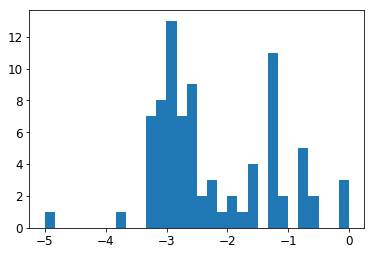

In [128]:
# Log-transformed histogram of weight fraction
plt.hist(np.log10(yarr_enm), bins=30)

In [408]:
# Define function to assign weight fractionchemical content s to bins per Isaacs et al. 2016
def bins(row):
    if row['maximum_weight_fraction'] <= 0.002:
        val = 'bottom'
    elif row['maximum_weight_fraction'] > 0.05:
        val = 'top'
    else:
        val = 'middle'
    return val

bin_enm = y_enm.apply(bins, axis=1)

Text(0.5,1,'Frequency of ENM Weight Fraction Bins')

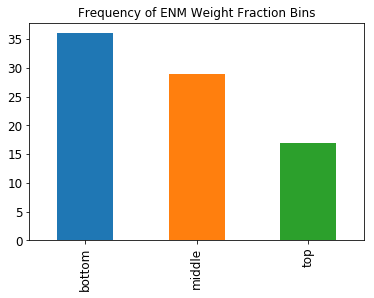

In [131]:
bin_enm.value_counts().plot(kind='bar')
plt.title('Frequency of ENM Weight Fraction Bins')

In [132]:
# Use label encoder to make bins compatible with Scikit-Learn
from sklearn import preprocessing
le2 = preprocessing.LabelEncoder()
# Fit the encoder and transform categories into integers
bin_num_enm = le2.fit_transform(bin_enm)
# Convert a list of integers into their category names
print('[0, 1, 2]')
print(list(le2.inverse_transform([0,1,2])))
print('bin_num_enm shape: {}'.format(bin_num_enm.shape))

[0, 1, 2]
['bottom', 'middle', 'top']
bin_num_enm shape: (82,)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Pre-processing

## Data distributions

In [334]:
# Setup colors for plotting pie charts
my_colors=["#1f77b4","#ff7f0e","#ffdf00","#d62728","#9467bd",
        "#2ca02c","#1034A6","#ffbf33","#8B0000",'teal',
        "#aada30","#e37799","#17becf","#7f7f7f","#cc0099","#0B6623"]

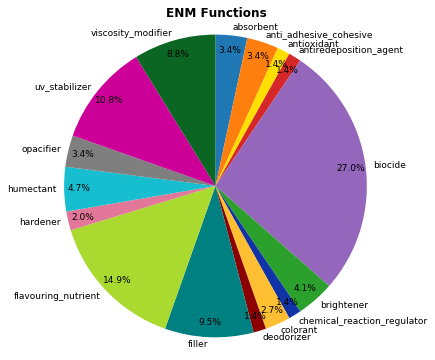

In [349]:
# ENM function breakdown as pie chart
from matplotlib import cm
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(Xf_enm.sum(axis=0), autopct='%1.1f%%', 
       colors=my_colors, 
       labels=enm_func_names, 
       pctdistance=0.9, labeldistance=1.05, 
       startangle=90, counterclock=False, 
       textprops={'fontsize':9})
ax.axis('equal')
ax.set_title("ENM Functions", weight="bold")
fig.savefig('./BLTfigs/pie_enm_function.png')
plt.show()

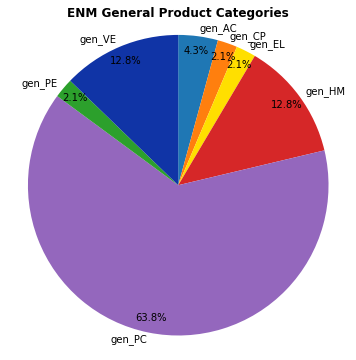

In [348]:
# ENM product category breakdown as pie chart
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(Xp_enm.values[:,0:7].sum(axis=0), autopct='%1.1f%%', 
       colors=my_colors, 
       labels=enm_PUC_names[0:7], 
       pctdistance=0.9, labeldistance=1.05, 
       startangle=90, counterclock=False, 
       textprops={'fontsize':10})
ax.axis('equal')
ax.set_title("ENM General Product Categories", weight="bold")
fig.savefig('./BLTfigs/pie_enm_gencat.png')
plt.show()

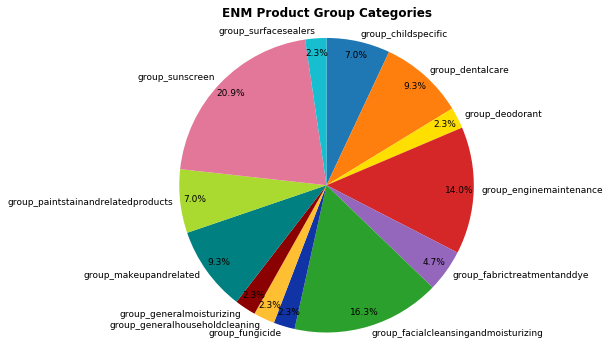

In [353]:
# ENM product category breakdown as pie chart
fig, ax = plt.subplots(figsize=(8,6))
ax.pie(Xp_enm.values[:,7:].sum(axis=0), autopct='%1.1f%%', 
       colors=my_colors,  
       labels=enm_PUC_names[7:], 
       pctdistance=0.9, labeldistance=1.05, 
       startangle=90, counterclock=False,
       textprops={'fontsize':9})
ax.axis('equal')
ax.set_title("ENM Product Group Categories", weight="bold")
fig.savefig('./BLTfigs/pie_enm_prodgroup.png')
plt.show()

In [338]:
Xp_enm.values[:,7:].sum(axis=0)

array([3, 4, 1, 6, 2, 7, 1, 1, 1, 4, 3, 9, 1], dtype=uint64)

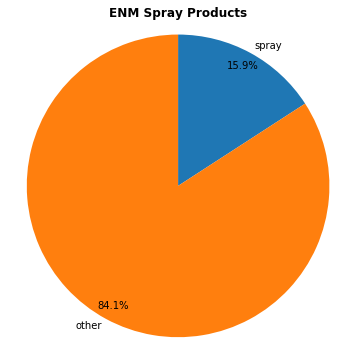

In [379]:
# ENM spray products as pie chart
fig, ax = plt.subplots(figsize=(6,6))
names = ['spray','other']
values = [(np.count_nonzero(X_enm['refined_spray'])), 
          (len(X_enm['refined_spray']) - np.count_nonzero(X_enm['refined_spray']))]
ax.pie(values, autopct='%1.1f%%', 
       colors=my_colors,
       labels=names, 
       pctdistance=0.9, labeldistance=1.05, 
       startangle=90, counterclock=False,
       textprops={'fontsize':10})
ax.axis('equal')
ax.set_title("ENM Spray Products", weight="bold")
fig.savefig('./BLTfigs/pie_enm_spray.png')
plt.show()

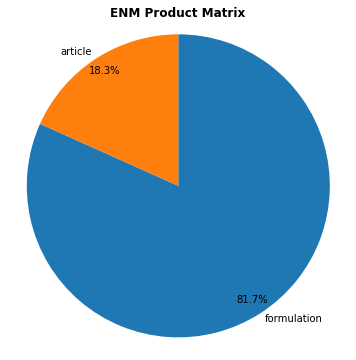

In [380]:
# ENM product matrices as pie chart
fig, ax = plt.subplots(figsize=(6,6))
names = ['formulation','article']
values = [(np.count_nonzero(X_enm['matrix_F'])), 
          (len(X_enm['matrix_F']) - np.count_nonzero(X_enm['matrix_F']))]
ax.pie(values, autopct='%1.1f%%', 
       colors=my_colors,  
       labels=names, 
       pctdistance=0.9, labeldistance=1.05, 
       startangle=90, counterclock=False,
       textprops={'fontsize':10})
ax.axis('equal')
ax.set_title("ENM Product Matrix", weight="bold")
fig.savefig('./BLTfigs/pie_enm_matrix.png')
plt.show()

## Preliminary performance check

In [208]:
# SVR-RBF with all features, normalized
    # Log-transformed weight fractions (NOT BINS!)
    # Explained variance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_enm,np.log10(yarr_enm))
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 0.7847599703514611, 'estimator__gamma': 0.00615848211066026}
0.031576335534540166


In [109]:
# SVR-RBF with all features, normalized
    # ENM weight fraction bins
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_enm,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 4832.930238571752, 'estimator__gamma': 0.0001623776739188721}
0.6097560975609756
accuracy


## PCA

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

***Need to add in cross-validation***

In [135]:
# Scale the data first (i.e., the chemical properties) so everything is from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_enm_scaled = scaler.fit_transform(X_enm)

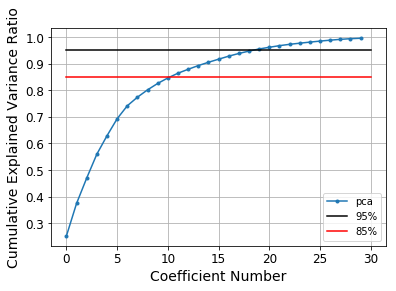

In [136]:
# Figure out number of components to achieve 85% cumulative explained variance
from sklearn import decomposition 
pca=decomposition.PCA(n_components=30)
dim_red_enm=pca.fit(X_enm_scaled)

fig =plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-',label='pca')
plt.plot([0, 30],[.95,.95],'k',label='95%')
plt.plot([0, 30],[.85,.85],'r',label='85%')
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

In [137]:
# PCA, 2 component
pca = decomposition.PCA(n_components=2)
pca.fit_transform(X_enm_scaled)

# Dump components relations with features:
#https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
pca_enm_df = pd.DataFrame(pca.components_,columns=X_enm.columns,index = ['PC-1','PC-2'])
pca_enm_df.to_csv('./data/enm_pca2component_2.csv')

In [138]:
# Transform/apply PCA
from sklearn import decomposition 
pca = decomposition.PCA(n_components=19)
dim_red_enm = pca.fit_transform(X_enm_scaled)

## Hierarchical Agglomerative Clustering (HAC)

### Dendrograms and elbow graph

* Feature Agglomeration sklearn http://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html
* Alternate approach
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [136]:
# Distance matrix using cosine
# ENM Functions and Product Category Features

from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

# https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity
res_enm = 1-pdist(Xfp_enm.T, 'cosine') # transform to find similarity between features (not datapoints)
distance_enm = pd.DataFrame(squareform(res_enm), index=enm_all_names, columns=enm_all_names)

In [137]:
distance_enm

,absorbent,anti_adhesive_cohesive,antioxidant,antiredeposition_agent,biocide,brightener,chemical_reaction_regulator,colorant,deodorizer,filler,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_make-upandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
absorbent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.478091,...,0.507093,0.000000,0.000000,0.000000,0.223607,0.000000,0.149071,0.000000,0.124035,0.273179
anti_adhesive_cohesive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316228,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.273179
antioxidant,0.000000,0.000000,0.000000,0.000000,0.111803,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172774
antiredeposition_agent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353553,0.000000,0.188982,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.196116,0.172774
biocide,0.000000,0.000000,0.111803,0.000000,0.000000,0.000000,0.000000,0.000000,0.223607,0.000000,...,0.059761,0.158114,0.158114,0.000000,0.000000,0.091287,0.000000,0.000000,0.350823,0.482917
brightener,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.462910,0.000000,0.000000,0.000000,0.408248,0.000000,0.136083,0.000000,0.000000,0.299253
chemical_reaction_regulator,0.000000,0.316228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172774
colorant,0.000000,0.000000,0.000000,0.353553,0.000000,0.000000,0.000000,0.000000,0.000000,0.133631,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.577350,0.166667,0.000000,0.000000,0.244339
deodorizer,0.000000,0.000000,0.000000,0.000000,0.223607,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.196116,0.086387
filler,0.478091,0.000000,0.000000,0.188982,0.000000,0.000000,0.000000,0.133631,0.000000,0.000000,...,0.202031,0.000000,0.000000,0.267261,0.267261,0.000000,0.534522,0.000000,0.296500,0.457116


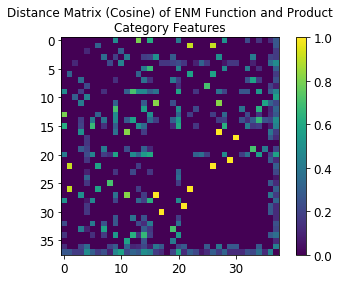

In [138]:
# ENM Functions and Product Category Features
from textwrap import wrap
fig=plt.imshow(distance_enm)
#plt.title('Distance Matrix (Cosine) of Function and Product Category Features')
plt.title("\n".join(wrap("Distance Matrix (Cosine) of ENM Function and Product Category Features", 60)))
plt.colorbar()
plt.savefig('./BLTfigs/enm_distmatrix_function-PUC_cosine.png')

Optimize the number of clusters using the elbow method, which estimates the clustering step where the acceleration of distance growth is largest.

In [146]:
# Generate linkage matrix
# ENM Functions only
from scipy.spatial.distance import squareform, pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage((Xf_enm.T), method='average', metric='cosine')

# Export Z-array for use in source model with format [idx1, idx2, dist, sample_count]
np.savetxt("./data/Zf_enm.csv", Z, delimiter="\t")

# Z-array with format [idx1, idx2, dist, sample_count]
Z[:5]

array([[ 0.  , 13.  ,  0.2 ,  2.  ],
       [ 9.  , 12.  ,  0.29,  2.  ],
       [ 5.  , 15.  ,  0.32,  2.  ],
       [14.  , 17.  ,  0.48,  3.  ],
       [ 4.  , 10.  ,  0.56,  2.  ]])

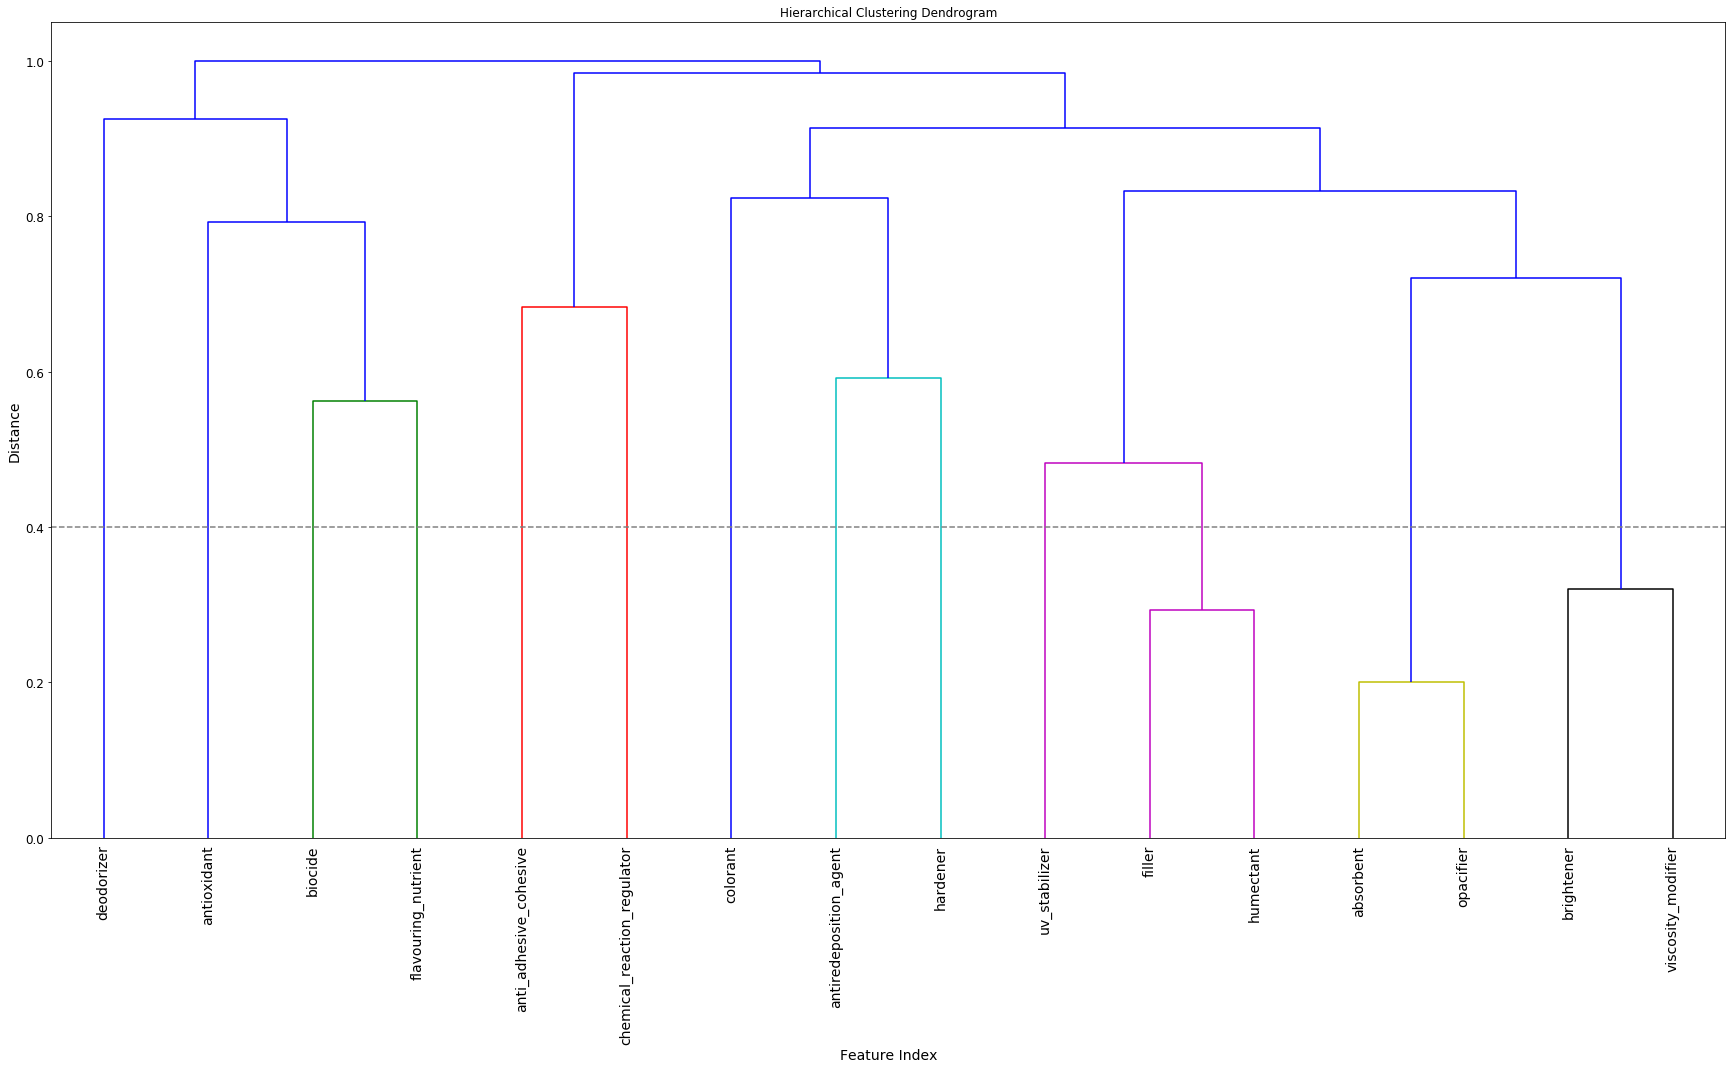

In [141]:
# Calculate full dendrogram
# ENM Functions only

fig=plt.figure(figsize=(30, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=14.,  # font size for the x axis labels
    labels=enm_func_names
)
plt.axhline(y=0.4, color='gray', linestyle='--')
plt.show()
savepdf(fig,'enm_cluster_dendrogram_func-only')

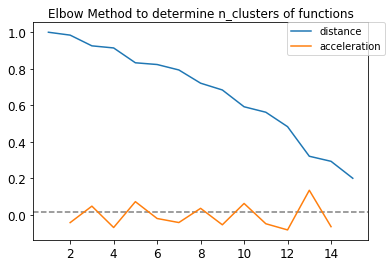

clusters: 13


In [69]:
# Optimize n_clusters with Elbow Method
# ENM functions only

last = Z[-16:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

plt.plot(idxs, last_rev, label='distance')
plt.axhline(y=0.016, color='gray', linestyle='--')
plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
plt.title('Elbow Method to determine n_clusters of functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
#plt.xlim([10,62])
#plt.ylim([-.05,.1])
plt.savefig('./BLTfigs/enm_elbow_func-only.png')
plt.show()

k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# look for spikes in orange
# 13,10,8

Now to repeat with ENM product categories.

In [72]:
# Generate linkage matrix
# ENM PUCs only
Z = linkage((Xp_enm.T), method='average', metric='cosine')
# Z-array with format [idx1, idx2, dist, sample_count]
np.savetxt("./BLTfigs/Z_puc.csv", Z, delimiter=",")

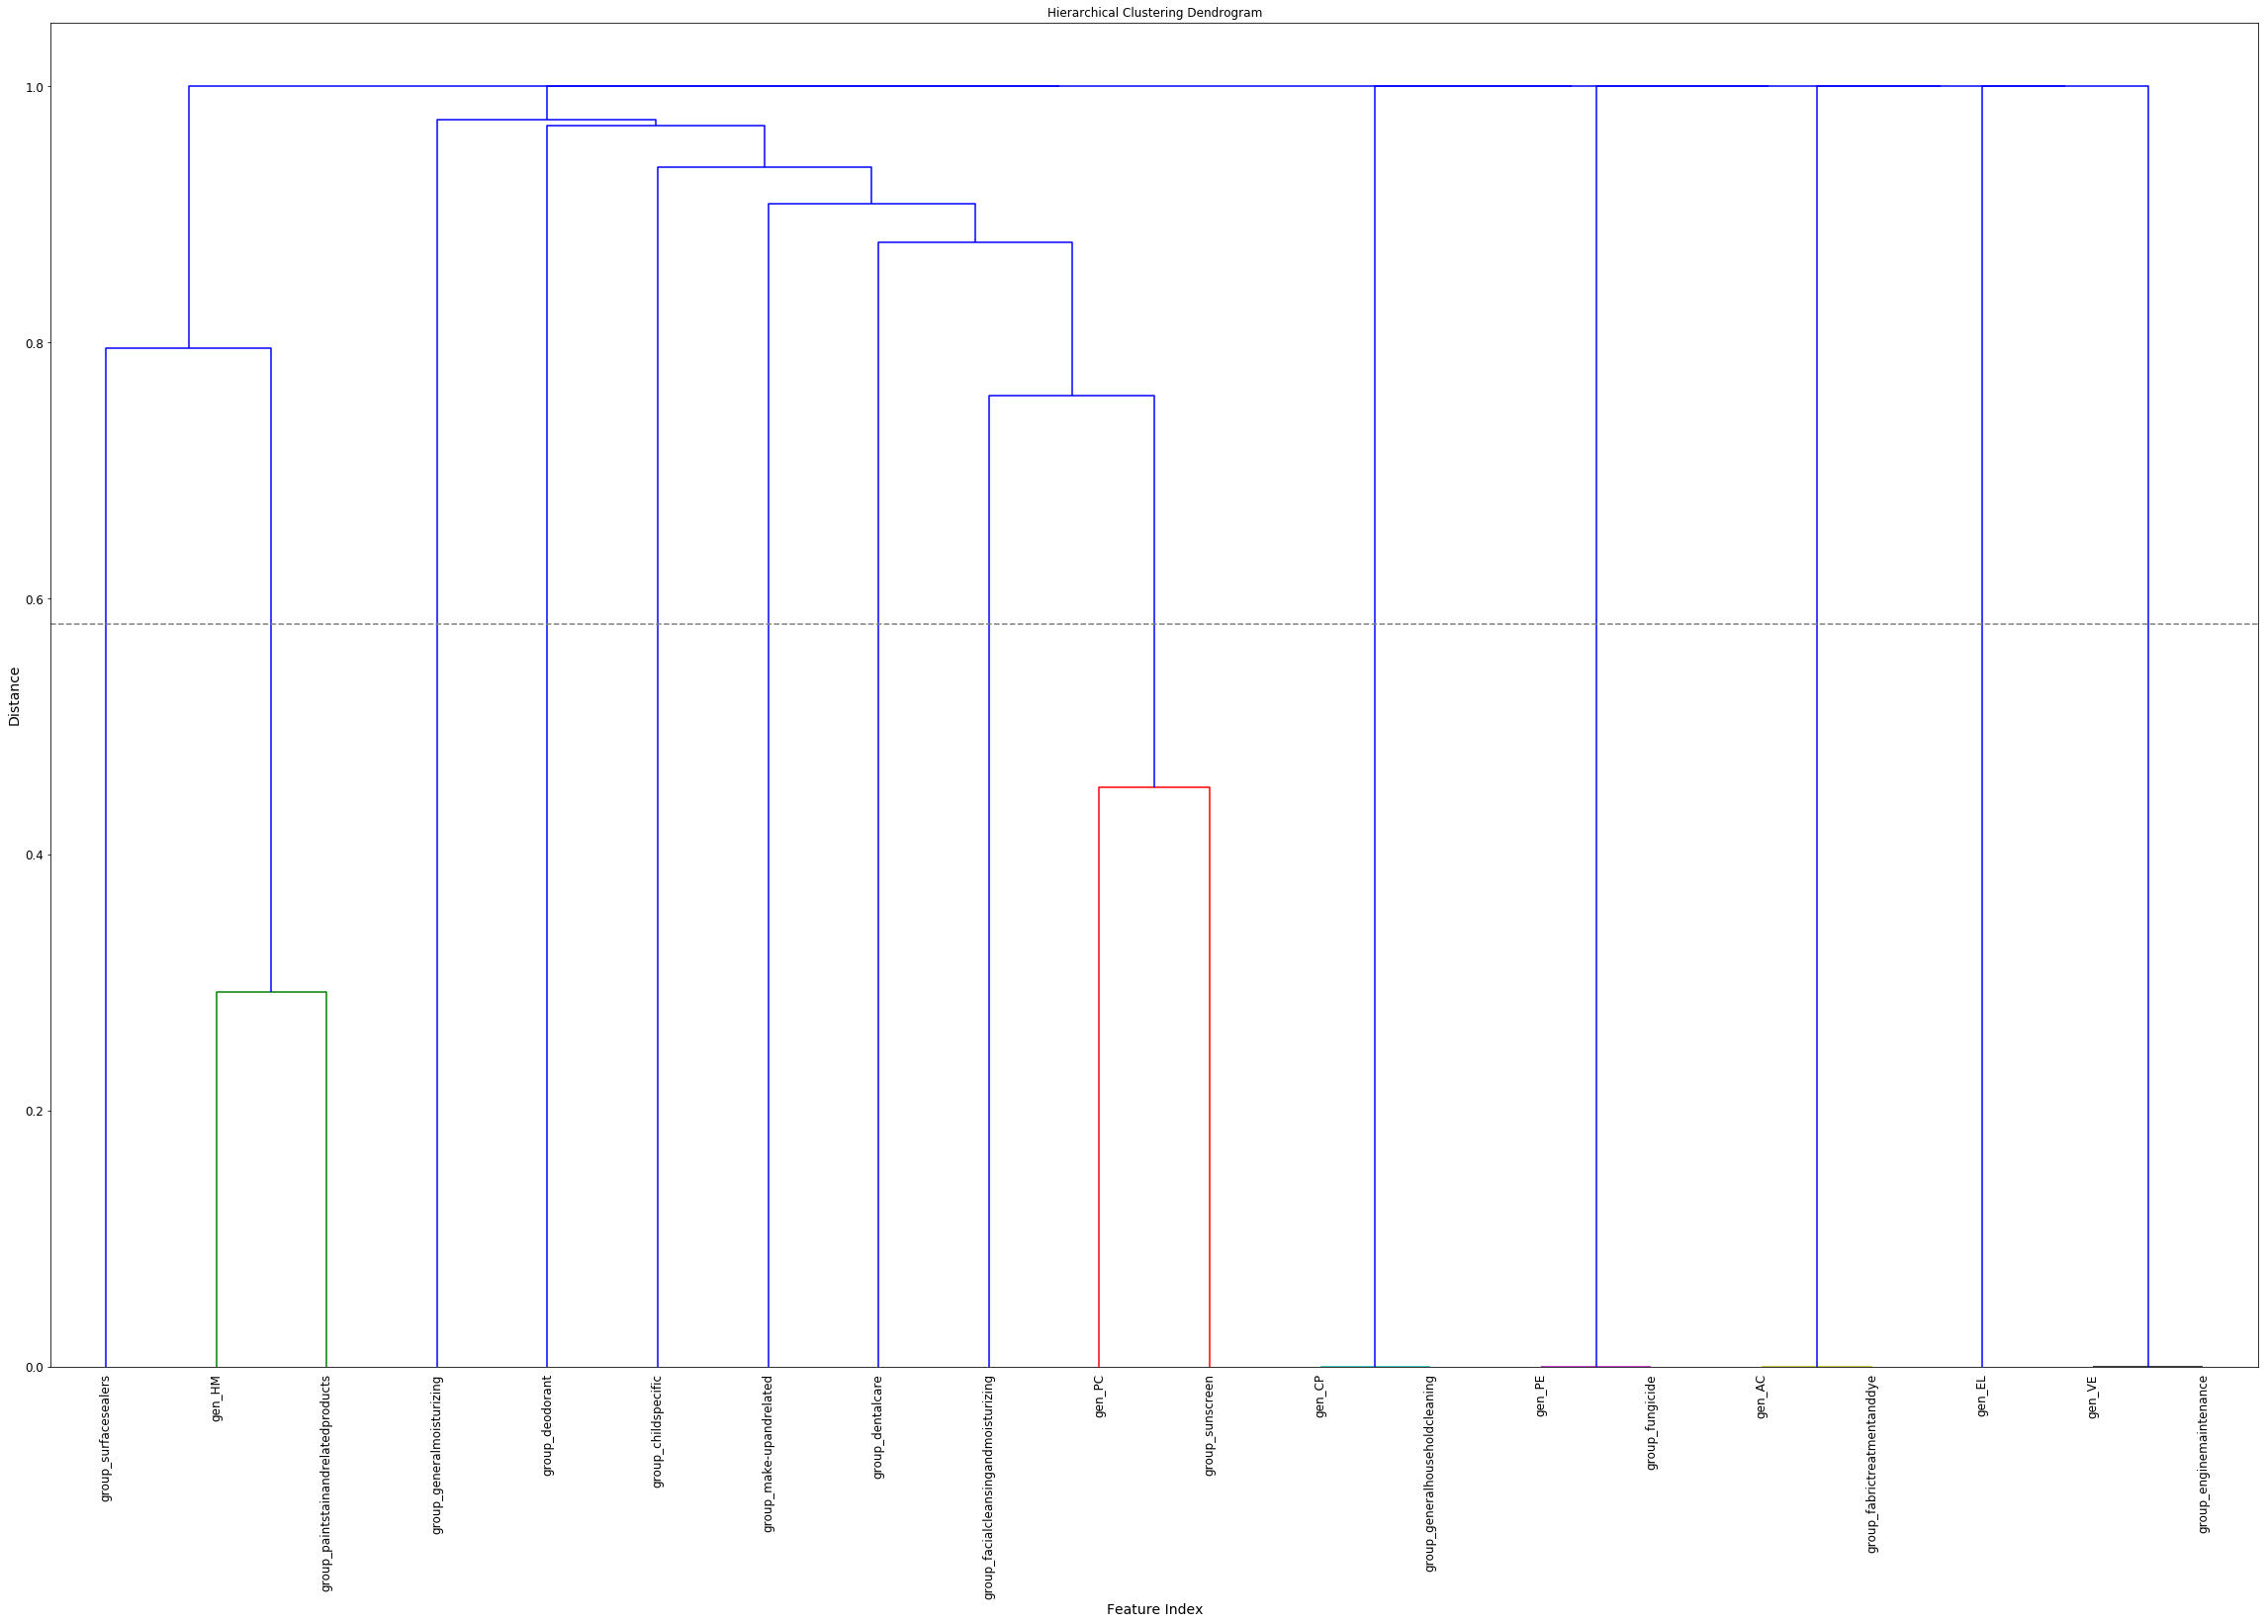

In [73]:
# Calculate full dendrogram
# ENM PUCs only

fig=plt.figure(figsize=(40, 25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    labels=enm_PUC_names
)
plt.axhline(y=0.58, color='gray', linestyle='--')
plt.show()
savepdf(fig,'enm_cluster_dendrogram_PUC-nomatrix')

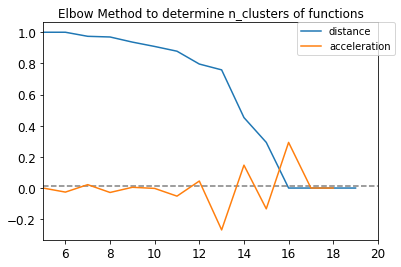

clusters: 16


In [79]:
# Optimize n_clusters with Elbow Method
# Organic functions only

last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]

plt.plot(idxs, last_rev, label='distance')
plt.axhline(y=0.016, color='gray', linestyle='--')
plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
plt.title('Elbow Method to determine n_clusters of functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.xlim([5,20])
#plt.ylim([-.05,.1])
plt.savefig('./BLTfigs/enm_elbow_PUC-nomatrix.png')
plt.show()

k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# look for spikes in orange

Clusters to try: 7,12,14,16

### Helper class for selecting best ENM estimator

Estimator Selection Helper by David Batista
http://www.davidsbatista.net/blog/2018/02/23/model_optimization/

In [80]:
# Set up for grid search across multiple pipelines
from sklearn.model_selection import GridSearchCV

cv=10
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=cv, n_jobs=1, verbose=1, scoring='accuracy', refit=False): # scoring=None
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [96]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=5
models_b = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

params_b = {
    'RandomForest': { 'n_estimators': [4,8,12,16]},
    'SVC': [
        {'kernel': ['linear'], 'C': np.logspace(0,2,5)},
        {'kernel': ['rbf'], 'C': np.logspace(0,2,5), 'gamma': np.logspace(-5,0,5)},
    ]
}

In [97]:
# Fit gridsearch models to select best estimator
# All ENM features only
helper_b = EstimatorSelectionHelper(models_b, params_b)
helper_b.fit(Xf_enm+0.00001, bin_num_enm, n_jobs=3)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Running GridSearchCV for SVC.
Fitting 10 folds for each of 220 candidates, totalling 2200 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Done 2200 out of 2200 | elapsed:    1.6s finished


In [98]:
# Compare performance for estimators (accuracy)
# Function features only
helper_b.score_summary(sort_by='mean_score')

RandomForest
SVC


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
102,SVC,0.444444,0.640873,1,0.200177,1.62378,0.215443,rbf,NaN
112,SVC,0.333333,0.638492,1,0.227326,3.35982,0.215443,rbf,NaN
11,SVC,0.333333,0.638492,1,0.227326,1.62378,NaN,linear,NaN
160,SVC,0.333333,0.624206,0.888889,0.20781,127.427,0.01,rbf,NaN
179,SVC,0.333333,0.624206,0.888889,0.20781,545.559,0.00215443,rbf,NaN
217,SVC,0.333333,0.624206,0.888889,0.20781,10000,0.0001,rbf,NaN
198,SVC,0.333333,0.624206,0.888889,0.20781,2335.72,0.000464159,rbf,NaN
159,SVC,0.444444,0.621825,1,0.196018,127.427,0.00215443,rbf,NaN
216,SVC,0.444444,0.621825,1,0.196018,10000,2.15443e-05,rbf,NaN
187,SVC,0.444444,0.621825,1,0.196018,1128.84,0.0001,rbf,NaN


In [99]:
# Fit gridsearch models to select best estimator
# All organics features only
helper_b = EstimatorSelectionHelper(models_b, params_b)
helper_b.fit(Xp_enm, bin_num_enm, n_jobs=3)

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Running GridSearchCV for SVC.
Fitting 10 folds for each of 220 candidates, totalling 2200 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Done 2200 out of 2200 | elapsed:    1.6s finished


In [100]:
# Compare performance for estimators (accuracy)
# Function features only
helper_b.score_summary(sort_by='mean_score')

RandomForest
SVC


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
0,RandomForest,0.333333,0.625198,0.857143,0.157606,NaN,NaN,NaN,4
93,SVC,0.333333,0.607143,0.857143,0.151138,0.78476,1,rbf,NaN
3,RandomForest,0.333333,0.602976,0.857143,0.15001,NaN,NaN,NaN,16
1,RandomForest,0.333333,0.602976,0.857143,0.15001,NaN,NaN,NaN,8
213,SVC,0.333333,0.596032,0.857143,0.150436,4832.93,1,rbf,NaN
203,SVC,0.333333,0.596032,0.857143,0.150436,2335.72,1,rbf,NaN
193,SVC,0.333333,0.596032,0.857143,0.150436,1128.84,1,rbf,NaN
183,SVC,0.333333,0.596032,0.857143,0.150436,545.559,1,rbf,NaN
173,SVC,0.333333,0.596032,0.857143,0.150436,263.665,1,rbf,NaN
163,SVC,0.333333,0.596032,0.857143,0.150436,127.427,1,rbf,NaN


### Pipeline/GridSearch to select n_clusters

Have to run fit with [X + a very small number] so that features with very few ones don't go missing during cross validation. https://stats.stackexchange.com/questions/324732/kernel-density-estimator-kde-with-too-many-zeroes-as-input

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#from sklearn import preprocessing

In [104]:
# Pipeline/GridSearch to select n_clusters for feature agglomeration
# after selecting ideal estimator
# ENM Functions only

# Pipeline
feat = FeatureAgglomeration(affinity="cosine", linkage="average")
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('feat', feat),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
k_set=[8,10,13,16]
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=3)
grid_search.fit(Xf_enm+.0001,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 3.359818286283781, 'estimator__gamma': 0.11288378916846883, 'feat__n_clusters': 13}
0.6585365853658537


In [107]:
# Pipeline/GridSearch to select n_clusters for feature agglomeration
# after selecting ideal estimator
# ENM PUCs only

# Pipeline
feat = FeatureAgglomeration(affinity="cosine", linkage="average")
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('feat', feat),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
k_set=[12,14,16,18]
c_set=np.logspace(-2,4,16)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'feat__n_clusters': k_set,
            'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=3)
grid_search.fit(Xp_enm+.0001,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1.0, 'estimator__gamma': 1.0, 'feat__n_clusters': 16}
0.5853658536585366


Turns out that not clustering the PUCs was the best performing option.

### Apply feature agglomeration using optimized n_clusters

In [140]:
# Apply feature agglomeration
# Functions only

from sklearn.cluster import FeatureAgglomeration

agg = FeatureAgglomeration(n_clusters=13, affinity="cosine", linkage="average")
agg.fit(Xf_enm+0.0001)
Xf_enm_red = agg.transform(Xf_enm)
agg.labels_

array([ 1,  9,  7, 10, 11,  0,  4,  6,  8,  2, 12,  3,  2,  1,  5,  0])

In [141]:
# TODO: with cross validation
# Apply feature agglomeration
# Functions only

# E.g., cross validation with PCA
# http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/

#agg = FeatureAgglomeration(n_clusters=13, affinity="cosine", linkage="average")

#num_folds = 10
#folds = model_selection.KFold(n_splits=num_folds,random_state=42)
#model_selection.cross_val_score(agg, X, y, scoring='accuracy', cv=folds)

#i=0
#for train_index, valid_index in folds.split(X,y):
    # Data Split
#    X_train, X_valid = X[train_index], X[valid_index]
#    y_train, y_valid = y[train_index], y[valid_index]
    # "Grid Search"
#    j=0
#    for alpha in alphas:
#        lin=linear_model.Lasso(alpha=alpha)
#        lin.fit(X_train, y_train)
#        all_train_mse[i,j]=metrics.mean_squared_error(y_train,lin.predict(X_train))
#        all_valid_mse[i,j]=metrics.mean_squared_error(y_valid,lin.predict(X_valid))
#        j+=1
#    i+=1
#    return agglo.labels_
#Xf_enm_red = agg.fit_transform(Xf_enm+0.0001) # fit to data, then transform it

In [142]:
Xf_enm_red = pd.DataFrame(Xf_enm_red)
print(Xf_enm_red.shape)

(82, 13)


In [144]:
# Apply feature agglomeration
# Product categories only

agg = FeatureAgglomeration(n_clusters=16, affinity="cosine", linkage="average")
Xp_enm_red = agg.fit_transform(Xp_enm+0.0001) # fit to data, then transform it

In [145]:
Xp_enm_red = pd.DataFrame(Xp_enm_red)
print(Xp_enm_red.shape)

(82, 16)


### Concatenate final dataframe

In [400]:
Xp_enm = pd.DataFrame(Xp_enm)
Xp_enm.columns = enm_PUC_names

In [401]:
# Concatenate all clustered and unscaled features into new dataframe
XX_enm = pd.concat([Xc_enm,Xf_enm_red,Xp_enm,Xm_enm], axis=1)
XX_enm.loc[0:3,]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
0,79.867,1843.00,2972.0,0.626340,0.5,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
1,63.546,1083.00,2567.0,0.952308,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,65.370,419.53,907.0,0.853698,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,107.868,961.78,2162.0,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1


In [402]:
# Export unscaled ENM dataframe
XX_enm.to_csv("./data/XX_enm.csv", sep='\t', na_rep='', header=True, index=True, index_label=None, mode='w')

In [116]:
# Scale pchem properties
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xc_enm_scaled = scaler.fit_transform(Xc_enm)
Xc_enm_scaled = pd.DataFrame(data=Xc_enm_scaled)

In [117]:
# Concatenate all clustered and scaled features into new (alternate) dataframe
XX_enm_scaled = pd.concat([Xc_enm_scaled,Xf_enm_red,Xp_enm,Xm_enm], axis=1)
XX_enm_scaled.loc[0:3,]
#XX_scaled=np.array(XX_scaled)
#print(XX_scaled.shape)

,0,1,2,3,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_make-upandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
0,0.159910,0.728168,0.611018,0.082634,0.5001,0.0001,0.0001,0.0001,0.0001,1.0001,...,0,0,0,0,0,1,0,0,0,1
1,0.078351,0.387819,0.502819,0.321179,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0,0,0,0,0,0,0,0,0,1
2,0.087466,0.090699,0.059336,0.229392,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0,0,0,0,0,0,0,0,0,1
3,0.299836,0.333533,0.394619,0.391028,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,1,0,0,0,0,0,0,0,0,1


# Core models

## Clustering, regression Model

In [118]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

#from sklearn import model_selection, metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

njobs=3
models = {
    'RandomForest': RandomForestRegressor(),
    'SVR': SVR()
}

params = {
    'RandomForest': { 'n_estimators': [4, 8, 12, 16] },
    'SVR': [
        {'kernel': ['linear'], 'C': [1, 10, 30]},
        {'kernel': ['rbf'], 'C': [1, 5, 10, 20, 30, 40, 50], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
    ]
}

In [119]:
# Fit gridsearch models to select best estimator

helper = EstimatorSelectionHelper(models, params)
helper.fit(XX_enm_scaled+0.0001, np.log10(yarr_enm), n_jobs=n_jobs, scoring='explained_variance') # n_jobs=1 by default

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Running GridSearchCV for SVR.
Fitting 10 folds for each of 38 candidates, totalling 380 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Done 380 out of 380 | elapsed:    0.5s finished


In [120]:
# Compare performance for estimators
helper.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
37,SVR,-0.62249,0.029433,0.468392,0.25752,50,0.0001,rbf,NaN
13,SVR,-0.620176,0.0294046,0.466755,0.256595,5,0.001,rbf,NaN
32,SVR,-0.494288,0.0283195,0.397619,0.209997,40,0.0001,rbf,NaN
27,SVR,-0.377818,0.026185,0.311364,0.162786,30,0.0001,rbf,NaN
22,SVR,-0.24717,0.0219887,0.216835,0.109803,20,0.0001,rbf,NaN
17,SVR,-0.12556,0.0135234,0.125604,0.0590009,10,0.0001,rbf,NaN
8,SVR,-0.125132,0.0134843,0.125293,0.0588247,1,0.001,rbf,NaN
12,SVR,-0.060599,0.00886199,0.0731525,0.0313175,5,0.0001,rbf,NaN
7,SVR,-0.0117708,0.00211383,0.0158261,0.00645745,1,0.0001,rbf,NaN
9,SVR,-1.22213,-0.00198798,0.597689,0.446432,1,0.01,rbf,NaN


## PCA, regression Model

In [121]:
# Fit gridsearch models to select best estimator

helper2 = EstimatorSelectionHelper(models, params)
helper2.fit(dim_red_enm, np.log10(yarr_enm), n_jobs=n_jobs, scoring='explained_variance') # n_jobs=1 by default

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Running GridSearchCV for SVR.
Fitting 10 folds for each of 38 candidates, totalling 380 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Done 380 out of 380 | elapsed:    0.5s finished


In [122]:
# Compare performance for estimators
helper2.score_summary(sort_by='mean_score')

RandomForest
SVR


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
32,SVR,-0.498523,0.0321473,0.416344,0.2158,40,0.0001,rbf,NaN
37,SVR,-0.62239,0.0317421,0.47422,0.260206,50,0.0001,rbf,NaN
13,SVR,-0.621387,0.0317064,0.473894,0.259846,5,0.001,rbf,NaN
27,SVR,-0.374299,0.0291626,0.328704,0.16597,30,0.0001,rbf,NaN
22,SVR,-0.247183,0.0255942,0.2301,0.113148,20,0.0001,rbf,NaN
17,SVR,-0.127033,0.0149769,0.129502,0.0606043,10,0.0001,rbf,NaN
8,SVR,-0.1266,0.0148968,0.128834,0.0603578,1,0.001,rbf,NaN
12,SVR,-0.0612442,0.00999065,0.0759484,0.0324261,5,0.0001,rbf,NaN
7,SVR,-0.0118853,0.00246785,0.0173036,0.0068765,1,0.0001,rbf,NaN
9,SVR,-1.21769,0.00236644,0.588368,0.447092,1,0.01,rbf,NaN


In [123]:
# Pipeline/GridSearch to find best optimized model
# after selecting ideal estimator

# Pipeline
estimator = SVR(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=[30,35,40,35]
gamma_set=[0.00003,0.0001,0.0003,0.001]

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='explained_variance', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
#grid_search.fit(XX,y_log)
grid_search.fit(dim_red_enm+.0001,np.log10(yarr_enm))
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__C': 40, 'estimator__gamma': 0.0003}
0.016344596124322503


## Compare feature predictivity

In [404]:
# SVR-RBF with WF bins
    # Function features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xf_enm+0.00001,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 1.623776739188721, 'estimator__gamma': 0.23357214690901212}
0.6341463414634146


In [405]:
# SVR-RBF with WF bins
    # Product category features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xp_enm+0.00001,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 0.7847599703514611, 'estimator__gamma': 1.0}
0.5975609756097561


In [406]:
# SVR-RBF with WF bins
    # Chemical property features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xc_enm+0.00001,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 127.42749857031322, 'estimator__gamma': 0.026366508987303555}
0.6097560975609756


In [407]:
# SVR-RBF with WF bins
    # Product matrix features
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(Xm_enm+0.00001,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 0.7847599703514611, 'estimator__gamma': 1.0}
0.4878048780487805


## NEW ENM Model (Clusters)

In [124]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(XX_enm,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 61.584821106602604, 'estimator__gamma': 0.012742749857031322}
0.6219512195121951
accuracy


Essentially leave one out cross validation, slight biases, might be overfitting

In [125]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', C=61.584821, gamma=0.01274275))
     ])

In [126]:
# Make a confusion matrix to summarize accuracy across labels
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [127]:
from sklearn import model_selection
kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True)
cnf_matrix2=np.zeros([3,3])
X=np.array(XX_enm)
y=np.array(bin_num_enm)
for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);

In [128]:
cnf_matrix=cnf_matrix2.astype(np.int)

Confusion matrix, without normalization
[[29  2  5]
 [11 15  3]
 [ 3  2 12]]
Normalized confusion matrix
[[0.81 0.06 0.14]
 [0.38 0.52 0.1 ]
 [0.18 0.12 0.71]]


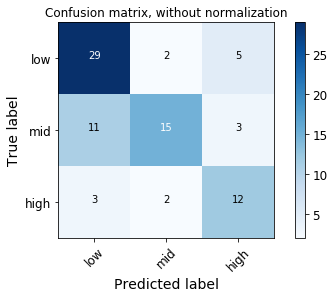

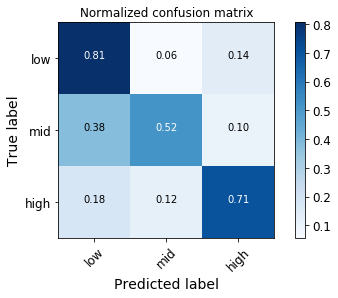

In [129]:
# Define confusion matrix
cnf_matrix = confusion_matrix(bin_num_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## NEW ENM Model (PCA)

In [159]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
#    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(-2,4,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(dim_red_enm,bin_num_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 0.37926901907322497, 'estimator__gamma': 0.11288378916846883}
0.5975609756097561


In [132]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', C=0.379269, gamma=0.112884))
     ])
bestpipe.fit(dim_red_enm,bin_num_enm)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=0.379269, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.112884, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [133]:
from sklearn import model_selection
kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True)
cnf_matrix2=np.zeros([3,3])
X=np.array(XX_enm)
y=np.array(bin_num_enm)
for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);

In [134]:
cnf_matrix=cnf_matrix2.astype(np.int)

Confusion matrix, without normalization
[[31  4  1]
 [13 13  3]
 [ 5  6  6]]
Normalized confusion matrix
[[0.86 0.11 0.03]
 [0.45 0.45 0.1 ]
 [0.29 0.35 0.35]]


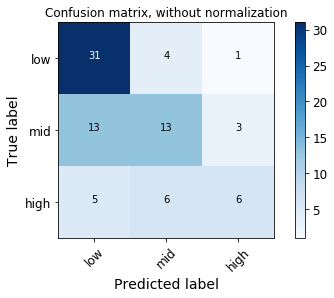

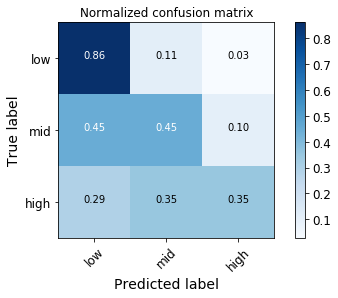

In [135]:
# Define confusion matrix
cnf_matrix = confusion_matrix(bin_num_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [153]:
# TODO: correlation matrix of features vs 
enm_corr = pd.concat(XX_enm,y_enm.apply(np.log10(), axis=1)) #np.log10(yarr_enm)
plt.matshow(enm_corr.corr())

ValueError: invalid number of arguments